# Supervised Learning Capstone

In [1]:
# importing packages we'll need
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading the data set
df = pd.read_csv('loan.csv', dtype = {'issue_d': str}, low_memory=False)
# https://www.kaggle.com/wendykan/lending-club-loan-data

This data set comes from Lending Club, an online peer-to-peer lending platform. In this notebook we will explore the data set, clean it, select features, and feed these features into several models. The goal of our models will be to run a regression to predict the interest rate offered for a given borrower's profile. The idea is to use the best trained model to evaluate prospective loans/borrowers; if the model's interest rate matches the rate offered then the loan is being properly valued. If the model's interest rate is higher than the offered rate, then an investor is not being adequately compensated for his risk, and should not invest. If the model's interest rate is lower than the rate offered, then the loan is undervalued and an investment is recommended.

## Data Exploration

In [3]:
df.shape

(1048575, 145)

In [4]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
list(df)

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Columns: 145 entries, id to settlement_term
dtypes: float64(71), int64(38), object(36)
memory usage: 1.1+ GB


We can see that there are 145 columns of data and over 1 million rows, each representing a unique loan. The list of columns is mostly self-explanatory. We can see that 36 of these columns are strings, which means they are likely to be categorical values. The remaining 109 columns are either floats or integers, likely suggesting continuous variables.

In [7]:
df.nunique()

id                                                 0
member_id                                          0
loan_amnt                                       1561
funded_amnt                                     1561
funded_amnt_inv                                 1580
term                                               2
int_rate                                         255
installment                                    69186
grade                                              7
sub_grade                                         35
emp_title                                     233592
emp_length                                        11
home_ownership                                     4
annual_inc                                     52275
verification_status                                3
issue_d                                           27
loan_status                                        7
pymnt_plan                                         2
url                                           

It's interesting to note that there are over 1,500 unique loan amounts, but over 69,000 unique interest rates. The grades (7) and subgrades (35) will probably be the most important categorical features in our model. We can also see that certain columns, such as 'url', are likely to be unimportant since they have 1 or 0 unique values.

In [8]:
df.isnull().sum()*100/df.isnull().count()

id                                            100.000000
member_id                                     100.000000
loan_amnt                                       0.000000
funded_amnt                                     0.000000
funded_amnt_inv                                 0.000000
term                                            0.000000
int_rate                                        0.000000
installment                                     0.000000
grade                                           0.000000
sub_grade                                       0.000000
emp_title                                       8.625420
emp_length                                      7.387645
home_ownership                                  0.000000
annual_inc                                      0.000000
verification_status                             0.000000
issue_d                                         0.000000
loan_status                                     0.000000
pymnt_plan                     

Here we can see what percentage of entries for any given column are null. We will use this information in the data cleaning process prior to building any models.<br> <br> Next, we'll take a look at how the numerical columns correlate with our target, the interest rate.

In [9]:
# filtering for numerical columns only
df_num = df.select_dtypes(exclude=['object'])
df_num.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,url,dti,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,13.56,84.92,55000.0,NaN,18.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,18.94,777.23,90000.0,NaN,26.52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,17.97,180.69,59280.0,NaN,10.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,18.94,146.51,92000.0,NaN,16.74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,16.14,731.78,57250.0,NaN,26.35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
col_names = list(df_num)

In [11]:
# displaying correlations
for i in col_names:
    print("{} and interest rate correlation is {}".format(i, df_num[i].corr(df_num['int_rate'])))

id and interest rate correlation is nan
member_id and interest rate correlation is nan
loan_amnt and interest rate correlation is 0.06697226362378149
funded_amnt and interest rate correlation is 0.06697357995593946
funded_amnt_inv and interest rate correlation is 0.06694671610251973
int_rate and interest rate correlation is 0.9999999999999998
installment and interest rate correlation is 0.10159058867491691
annual_inc and interest rate correlation is -0.07336469442038507
url and interest rate correlation is nan
dti and interest rate correlation is 0.13085444536568852
delinq_2yrs and interest rate correlation is 0.062226268767203115
inq_last_6mths and interest rate correlation is 0.16274004714640447
mths_since_last_delinq and interest rate correlation is -0.051079784413263
mths_since_last_record and interest rate correlation is -0.018507672738113087
open_acc and interest rate correlation is -0.012564465436055211
pub_rec and interest rate correlation is 0.051749037607456215
revol_bal and 

This is good information, but it is a little difficult to wade through. Let's create a sortable dataframe to more easily understand the correlation relationships.

In [12]:
corr_list = []
for i in col_names:
    corr_list.append(df_num[i].corr(df_num['int_rate']))

In [13]:
new_df = pd.DataFrame()

In [14]:
new_df['term'] = col_names
new_df['corr'] = corr_list
new_df.head()

,term,corr
0,id,NaN
1,member_id,NaN
2,loan_amnt,0.066972
3,funded_amnt,0.066974
4,funded_amnt_inv,0.066947


In [15]:
new_df.sort_values(by=['corr'], ascending=False)

,term,corr
5,int_rate,1.000000
100,hardship_amount,0.636597
103,orig_projected_additional_accrued_interest,0.627249
24,total_rec_int,0.373019
106,settlement_amount,0.337066
104,hardship_payoff_balance_amount,0.294277
47,all_util,0.294212
55,bc_util,0.265513
93,sec_app_revol_util,0.261570
82,percent_bc_gt_75,0.260068


Now this list will help inform our decisions about which columns/features are likely to be useful in predicting interest rate.<br> <br> Finally, let's take a look at the list of columns with data type string so that we can get a good idea of what categorical values will be available as potential features.

In [16]:
df_obj = df.select_dtypes(include=['object'])
list(df_obj)

['term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'verification_status_joint',
 'sec_app_earliest_cr_line',
 'hardship_flag',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_loan_status',
 'disbursement_method',
 'debt_settlement_flag',
 'debt_settlement_flag_date',
 'settlement_status',
 'settlement_date']

## Data Cleaning and Feature Selection

I want to take two parallel approaches to selecting features. The first approach is manual. I will simply select the features that I believe to be relevant and useful, referring to their correlations with interest rate and using common knowledge as to what factors might go into determining the interest rate on a loan. <br> <br> The second approach is to start with a much larger, bulk feature list, and from there try to use principle component analysis to reduce dimensionality. One important note here is that I will be excluding any columns with information that would not be available before a loan is issued. This is being done to stay consistent with the stated intent of this project, which is to use the end model as an investment decision tool.

In [17]:
# creating the manual feature list
manual_feat_list = ['int_rate', 'all_util', 'percent_bc_gt_75', 'dti_joint', 'num_tl_op_past_12m', 'inq_last_6mths', 'open_il_12m', 'bc_open_to_buy', 'total_bc_limit', 'mo_sin_old_rev_tl_op', 'sec_app_mort_acc', 'annual_inc_joint', 'pub_rec_bankruptcies', 'term', 'sub_grade', 'home_ownership']

In [18]:
# creating the bulk feature list
bulk_feat_list = ['int_rate', 'all_util', 'bc_util', 'percent_bc_gt_75', 'revol_util', 'dti_joint', 'num_tl_op_past_12m', 'inq_last_6mths', 'inq_last_12m', 'open_il_12m', 'open_il_24m', 'il_util', 'open_acc_6m', 'inq_fi', 'dti', 'open_rv_24m', 'open_rv_12m', 'sec_app_inq_last_6mths', 'bc_open_to_buy', 'total_bc_limit', 'total_rev_hi_lim', 'mo_sin_old_rev_tl_op', 'sec_app_mort_acc', 'mths_since_recent_inq', 'tot_hi_cred_lim', 'annual_inc_joint', 'mort_acc', 'mo_sin_rcnt_tl', 'mths_since_rcnt_il', 'num_bc_tl', 'pct_tl_nvr_dlq', 'mo_sin_rcnt_rev_tl_op', 'tot_cur_bal', 'avg_cur_bal', 'sec_app_num_rev_accts', 'annual_inc', 'num_rev_accts', 'num_bc_sats', 'max_bal_bc', 'pub_rec_bankruptcies', 'term', 'sub_grade', 'home_ownership', 'emp_length', 'purpose', 'earliest_cr_line', 'mths_since_recent_bc', 'sec_app_mths_since_last_major_derog']

In [19]:
# creating a dataframe with only the selected manual features
man_df = pd.DataFrame()
man_df = df.filter(items=manual_feat_list)
man_df.head()

,int_rate,all_util,percent_bc_gt_75,dti_joint,num_tl_op_past_12m,inq_last_6mths,open_il_12m,bc_open_to_buy,total_bc_limit,mo_sin_old_rev_tl_op,sec_app_mort_acc,annual_inc_joint,pub_rec_bankruptcies,term,sub_grade,home_ownership
0,13.56,28.0,0.0,NaN,3,1.0,1.0,34360.0,36500,212,NaN,NaN,1,36 months,C1,RENT
1,18.94,57.0,0.0,NaN,6,0.0,2.0,13761.0,15000,378,NaN,NaN,1,60 months,D2,MORTGAGE
2,17.97,35.0,0.0,NaN,0,0.0,0.0,13800.0,13800,92,NaN,NaN,0,36 months,D1,MORTGAGE
3,18.94,70.0,100.0,NaN,3,0.0,3.0,1239.0,5000,154,NaN,NaN,0,36 months,D2,MORTGAGE
4,16.14,54.0,0.0,NaN,5,0.0,3.0,8471.0,9300,216,NaN,NaN,0,60 months,C4,MORTGAGE


In [20]:
# creating a dataframe with only the bulk features
bulk_df = pd.DataFrame()
bulk_df = df.filter(items=bulk_feat_list)
bulk_df.head()

,int_rate,all_util,bc_util,percent_bc_gt_75,revol_util,dti_joint,num_tl_op_past_12m,inq_last_6mths,inq_last_12m,open_il_12m,...,max_bal_bc,pub_rec_bankruptcies,term,sub_grade,home_ownership,emp_length,purpose,earliest_cr_line,mths_since_recent_bc,sec_app_mths_since_last_major_derog
0,13.56,28.0,5.9,0.0,10.3,NaN,3,1.0,2.0,1.0,...,2137.0,1,36 months,C1,RENT,10+ years,debt_consolidation,Apr-01,1.0,NaN
1,18.94,57.0,8.3,0.0,24.2,NaN,6,0.0,2.0,2.0,...,998.0,1,60 months,D2,MORTGAGE,10+ years,debt_consolidation,Jun-87,4.0,NaN
2,17.97,35.0,0.0,0.0,19.1,NaN,0,0.0,0.0,0.0,...,0.0,0,36 months,D1,MORTGAGE,6 years,debt_consolidation,Apr-11,77.0,NaN
3,18.94,70.0,75.2,100.0,78.1,NaN,3,0.0,3.0,3.0,...,3761.0,0,36 months,D2,MORTGAGE,10+ years,debt_consolidation,Feb-06,64.0,NaN
4,16.14,54.0,8.9,0.0,3.6,NaN,5,0.0,0.0,3.0,...,516.0,0,60 months,C4,MORTGAGE,10+ years,debt_consolidation,Dec-00,2.0,NaN


Now we will get dummy values for the categorical features in the manual feature list.

In [21]:
man_df = pd.concat([man_df, pd.get_dummies(man_df['term'], drop_first=True)], axis=1)

In [22]:
man_df = pd.concat([man_df, pd.get_dummies(man_df['home_ownership'], drop_first=True)], axis=1)

In [23]:
man_df = pd.concat([man_df, pd.get_dummies(man_df['sub_grade'], drop_first=True)], axis=1)

In [24]:
man_df.head()

,int_rate,all_util,percent_bc_gt_75,dti_joint,num_tl_op_past_12m,inq_last_6mths,open_il_12m,bc_open_to_buy,total_bc_limit,mo_sin_old_rev_tl_op,...,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5
0,13.56,28.0,0.0,NaN,3,1.0,1.0,34360.0,36500,212,...,0,0,0,0,0,0,0,0,0,0
1,18.94,57.0,0.0,NaN,6,0.0,2.0,13761.0,15000,378,...,0,0,0,0,0,0,0,0,0,0
2,17.97,35.0,0.0,NaN,0,0.0,0.0,13800.0,13800,92,...,0,0,0,0,0,0,0,0,0,0
3,18.94,70.0,100.0,NaN,3,0.0,3.0,1239.0,5000,154,...,0,0,0,0,0,0,0,0,0,0
4,16.14,54.0,0.0,NaN,5,0.0,3.0,8471.0,9300,216,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# dropping the string columns now that we've gotten dummies
man_df = man_df.drop('sub_grade', 1)
man_df = man_df.drop('home_ownership', 1)
man_df = man_df.drop('term', 1)

In [26]:
man_df.head()

,int_rate,all_util,percent_bc_gt_75,dti_joint,num_tl_op_past_12m,inq_last_6mths,open_il_12m,bc_open_to_buy,total_bc_limit,mo_sin_old_rev_tl_op,...,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5
0,13.56,28.0,0.0,NaN,3,1.0,1.0,34360.0,36500,212,...,0,0,0,0,0,0,0,0,0,0
1,18.94,57.0,0.0,NaN,6,0.0,2.0,13761.0,15000,378,...,0,0,0,0,0,0,0,0,0,0
2,17.97,35.0,0.0,NaN,0,0.0,0.0,13800.0,13800,92,...,0,0,0,0,0,0,0,0,0,0
3,18.94,70.0,100.0,NaN,3,0.0,3.0,1239.0,5000,154,...,0,0,0,0,0,0,0,0,0,0
4,16.14,54.0,0.0,NaN,5,0.0,3.0,8471.0,9300,216,...,0,0,0,0,0,0,0,0,0,0


In [27]:
man_df.fillna(0, inplace=True)

Finally, we replace all NaN values with zeroes in the manual features dataframe. Our manual features are now ready to feed into a model. Now we'll clean and format the bulk features data.

In [28]:
#checking for null values in our bulk features
bulk_df.isnull().sum()*100/bulk_df.isnull().count()

int_rate                                0.000000
all_util                                9.323797
bc_util                                 1.225950
percent_bc_gt_75                        1.193620
revol_util                              0.085926
dti_joint                              92.534535
num_tl_op_past_12m                      0.000000
inq_last_6mths                          0.000095
inq_last_12m                            9.309396
open_il_12m                             9.309301
open_il_24m                             9.309301
il_util                                22.749160
open_acc_6m                             9.309396
inq_fi                                  9.309301
dti                                     0.114155
open_rv_24m                             9.309301
open_rv_12m                             9.309301
sec_app_inq_last_6mths                 93.421071
bc_open_to_buy                          1.180078
total_bc_limit                          0.000000
total_rev_hi_lim    

In [29]:
bulk_df = pd.concat([bulk_df, pd.get_dummies(bulk_df['earliest_cr_line'], drop_first=True)], axis=1)
bulk_df = pd.concat([bulk_df, pd.get_dummies(bulk_df['purpose'], drop_first=True)], axis=1)
bulk_df = pd.concat([bulk_df, pd.get_dummies(bulk_df['emp_length'], drop_first=True)], axis=1)
bulk_df = pd.concat([bulk_df, pd.get_dummies(bulk_df['home_ownership'], drop_first=True)], axis=1)
bulk_df = pd.concat([bulk_df, pd.get_dummies(bulk_df['term'], drop_first=True)], axis=1)
bulk_df = pd.concat([bulk_df, pd.get_dummies(bulk_df['sub_grade'], drop_first=True)], axis=1)

In [30]:
bulk_df = bulk_df.drop('sub_grade', 1)
bulk_df = bulk_df.drop('term', 1)
bulk_df = bulk_df.drop('home_ownership', 1)
bulk_df = bulk_df.drop('emp_length', 1)
bulk_df = bulk_df.drop('purpose', 1)
bulk_df = bulk_df.drop('earliest_cr_line', 1)
bulk_df = bulk_df.drop('mths_since_recent_bc', 1)
bulk_df = bulk_df.drop('sec_app_mths_since_last_major_derog', 1)
bulk_df = bulk_df.drop('mths_since_rcnt_il', 1)
bulk_df = bulk_df.drop('mths_since_recent_inq', 1)

We've got our dummies for the categorical features and dropped the original string columns. I also decided to drop 4 columns that store information about time (months) since a certain event took place. For the rest of the columns replacing NaN values with zeroes makes sense, and might even be accurate; however, for these columns adding zeroes would likely weaken the model.

In [31]:
# filling Nan with 0
bulk_df.fillna(0, inplace=True)

## PCA- Bulk Features

The manual features are ready to go, but now we need to perform PCA to try to reduce the size of the bulk features list.

In [32]:
X_pca = StandardScaler().fit_transform(bulk_df)
Xt_pca = X_pca.T
Cx = np.cov(Xt_pca)
Cx

array([[ 1.00000095e+00,  2.41398216e-01,  2.50196690e-01, ...,
         7.91885674e-02,  6.88686231e-02,  6.43194733e-02],
       [ 2.41398216e-01,  1.00000095e+00,  3.81971745e-01, ...,
         1.01274129e-02,  8.67291979e-03,  9.33288788e-03],
       [ 2.50196690e-01,  3.81971745e-01,  1.00000095e+00, ...,
         8.80265691e-03,  8.60770583e-03,  8.09577650e-03],
       ...,
       [ 7.91885674e-02,  1.01274129e-02,  8.80265691e-03, ...,
         1.00000095e+00, -4.97378322e-04, -4.54026183e-04],
       [ 6.88686231e-02,  8.67291979e-03,  8.60770583e-03, ...,
        -4.97378322e-04,  1.00000095e+00, -3.86689042e-04],
       [ 6.43194733e-02,  9.33288788e-03,  8.09577650e-03, ...,
        -4.54026183e-04, -3.86689042e-04,  1.00000095e+00]])

In [33]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

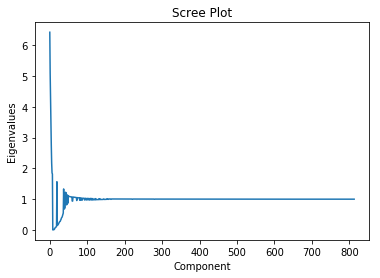

[6.42472959e+00 5.07654621e+00 4.28129552e+00 3.31903449e+00
 2.75362265e+00 2.17604976e+00 1.85492367e+00 1.81593516e+00
 9.58567470e-04 5.51103366e-03 3.54772968e-03 1.70682344e-02
 1.63746143e-02 4.22060351e-02 6.25535490e-02 8.51592306e-02
 9.00448328e-02 9.94169551e-02 1.06732618e-01 1.56622846e+00
 1.52238855e-01 1.58766323e-01 1.66334604e-01 1.90026555e-01
 2.12466774e-01 2.36321355e-01 2.63938455e-01 2.72397985e-01
 2.82273711e-01 3.21254543e-01 3.40394438e-01 3.85098558e-01
 4.02068503e-01 4.21256669e-01 4.68561425e-01 5.19920429e-01
 5.50348392e-01 1.33224898e+00 6.79377615e-01 6.82199665e-01
 7.08706184e-01 7.24321653e-01 1.22356628e+00 1.21144588e+00
 1.20084065e+00 8.15462195e-01 8.40044768e-01 1.13662568e+00
 8.67019381e-01 1.11586923e+00 1.10176937e+00 1.09249399e+00
 1.08986252e+00 1.08354795e+00 1.08024301e+00 1.07622376e+00
 1.07570863e+00 1.07598169e+00 1.07158729e+00 1.07137319e+00
 9.36550111e-01 9.37960013e-01 1.06934503e+00 1.06731013e+00
 1.06634321e+00 1.064566

In [39]:
# print scree plot
plt.plot(eig_val_cov)
plt.ylabel('Eigenvalues')
plt.xlabel('Component')
plt.title('Scree Plot')
plt.show()

print(eig_val_cov)

This plot is not very useful. Let's zoom in to try to better understand how many features score significantly above 1.

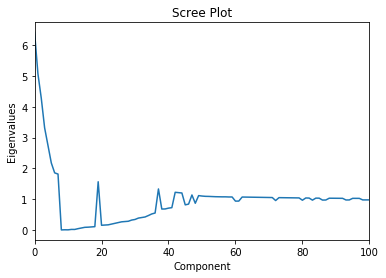

In [40]:
# print scree plot
plt.plot(eig_val_cov)
plt.xlim(0, 100)
plt.ylabel('Eigenvalues')
plt.xlabel('Component')
plt.title('Scree Plot')
plt.show()


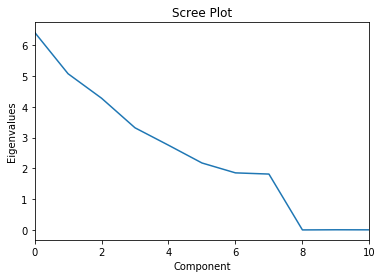

In [41]:
# print scree plot
plt.plot(eig_val_cov)
plt.xlim(0, 10)
plt.ylabel('Eigenvalues')
plt.xlabel('Component')
plt.title('Scree Plot')
plt.show()


We can see from this last plot that there are 7 components that score near 2 or higher. Also, looking through the list of scores above shows 16 components that score above 1.2. Let's try performing PCA with 16 components.

In [34]:
sklearn_pca = PCA(n_components=16)
Y_sklearn = sklearn_pca.fit_transform(X_pca)

P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt_pca)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.00789278 0.00623654 0.00525957 0.00407743 0.0033828  0.00267218
 0.00227433 0.00222418 0.00187162 0.0014019  0.00133839 0.00129431
 0.00128337 0.0012524  0.00124846 0.00124377]


This is not very good at all. The component with the most explanatory value of all explains only 0.79% of the variance within the data set. The explanatory power of these components is so weak that we will abandon PCA and the bulk features method from here forward. After we performed one hot encoding earlier our dataframe became populated with hundreds of columns that are primarily filled with zeroes and a few, sparse ones. This probably made PCA ineffective, and definitely made it take longer to run.

## OLS- Manual Features

In [35]:
# Y is the target variable
Y = man_df['int_rate']
# X is the feature set
X = man_df.iloc[:, 1:]
# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, random_state = 465)

In [37]:
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 891288
The number of observations in test set is 157287


In [38]:
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               int_rate   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                 6.468e+05
Date:                Sun, 28 Jul 2019   Prob (F-statistic):               0.00
Time:                        04:33:04   Log-Likelihood:            -1.0803e+06
No. Observations:              891288   AIC:                         2.161e+06
Df Residuals:                  891237   BIC:                         2.161e+06
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.9153 

In [39]:
X_test = sm.add_constant(X_test)

# We fit an OLS model using statsmodels
results = sm.OLS(y_test, X_test).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               int_rate   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                 1.141e+05
Date:                Sun, 28 Jul 2019   Prob (F-statistic):               0.00
Time:                        04:33:05   Log-Likelihood:            -1.9012e+05
No. Observations:              157287   AIC:                         3.804e+05
Df Residuals:                  157236   BIC:                         3.809e+05
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.8655 

## Ridge Regression- Manual Features

In [40]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [41]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print('The regularization gap is: {}'.format(ridge_cv.score(X_train, y_train) -ridge_cv.score(X_test, y_test)))

Best alpha value is: 0.001
R-squared of the model in training set is: 0.973179359636984
-----Test set statistics-----
R-squared of the model in test set is: 0.9731609380819822
Mean absolute error of the prediction is: 0.5686614037724771
Mean squared error of the prediction is: 0.6573995294652771
Root mean squared error of the prediction is: 0.8108017818587211
Mean absolute percentage error of the prediction is: 4.406685812311066
The regularization gap is: 1.842155500175746e-05


## Lasso Regression- Manual Features

In [42]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print('The regularization gap is: {}'.format(lasso_cv.score(X_train, y_train) - lasso_cv.score(X_test, y_test)))

Best alpha value is: 1e-08
R-squared of the model in training set is: 0.9731791271015281
-----Test set statistics-----
R-squared of the model in test set is: 0.9731609192937625
Mean absolute error of the prediction is: 0.5686693150092454
Mean squared error of the prediction is: 0.6573999896664147
Root mean squared error of the prediction is: 0.8108020656525331
Mean absolute percentage error of the prediction is: 4.406674563657048
The regularization gap is: 1.8207807765624473e-05


## ElasticNet Regression- Manual Features

In [43]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print('The regularization gap is: {}'.format(elasticnet_cv.score(X_train, y_train) - elasticnet_cv.score(X_test, y_test)))

Best alpha value is: 1e-08
R-squared of the model in training set is: 0.9731791271476845
-----Test set statistics-----
R-squared of the model in test set is: 0.9731609203217968
Mean absolute error of the prediction is: 0.5686695240627828
Mean squared error of the prediction is: 0.6573999644856067
Root mean squared error of the prediction is: 0.8108020501242006
Mean absolute percentage error of the prediction is: 4.406680295728165
The regularization gap is: 1.8206825887712164e-05


## SVR & Decision Forest Regression

I also attempted to perform a Support Vector Regression and a Decision Forest Regression on the manual features, but after approximately 20 minutes of runtime on each model with no results I decided to abandon those options and conclude that the size of this data set and the number of features in the data set preclude these models from being a best choice. 